# 이미지 분류 모델
- MNIST 이미지는 흑백 이미지 즉, channel 수가 1개
- 여기서는 CIFA10 이라는 컬러 이미지 즉, channel 수가 3개인 이미지 데이터를 가지고 분류 모데를 만들어 본다.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
DIR_ROOT_DATA = "../data"
BATCH_SIZE = 256
LEARNING_RATE = 0.001
EPOCHS = 50

## CIFAR 10 데이터셋

- CIFAR-10 데이터셋은 10개의 클래스로 구성된 60,000개의 32x32 컬러 이미지입니다.
- 각 클래스당 6,000개의 이미지가 있습니다. 
- 50,000개의 훈련용 이미지와 10,000개의 테스트용 이미지로 구성되어 있습니다.
- 다음은 데이터셋의 클래스들입니다.
    - 0: 비행기
    - 1: 자동차
    - 2: 새
    - 3: 고양이
    - 4: 사슴
    - 5: 개
    - 6: 개구리
    - 7: 말
    - 8: 배
    - 9: 트럭
- [참고 링크](https://www.cs.toronto.edu/~kriz/cifar.html)


In [3]:
transform = transforms.ToTensor()

train_set = torchvision.datasets.CIFAR10(
    root=DIR_ROOT_DATA, train=True, download=True, transform=transform
)
train_data_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

test_set = torchvision.datasets.CIFAR10(
    root=DIR_ROOT_DATA, train=False, download=True, transform=transform
)
test_data_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


### 예시 이미지
- CIFAR 10 데이터셋 중 이미지 한 개를 확인해보겠습니다.

shape of images: torch.Size([256, 3, 32, 32])
shape of labels: torch.Size([256])
label: 0 which is: 비행기


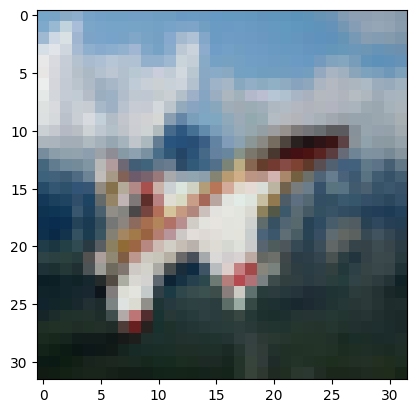

In [4]:
from matplotlib import pyplot as plt

# 레이블에 해당하는 종류를 글자로 바꿀 수 있도록 tuple 을 준비
names = ("비행기", "자동차", "새", "고양이", "사슴", "개", "개구리", "말", "배", "트럭")

images, labels = next(iter(train_data_loader))

print("shape of images:", images.shape)
print("shape of labels:", labels.shape)

print("label:", labels[0].item(), "which is:", names[labels[0].item()])
plt.imshow(transforms.ToPILImage()(images[0]))

In [5]:
class SimpleImageClassificationModel(nn.Module):
    def __init__(self, num_channels, image_width, image_height, num_output_classes):
        super(SimpleImageClassificationModel, self).__init__()

        hidden_dim = 2048
        input_size = num_channels * image_width * image_height

        self.layer1 = nn.Linear(input_size, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, num_output_classes)

        self.activation = nn.LeakyReLU()

    def forward(self, x):
        # x.shape is (batch_size, channels, width, height)
        x = torch.flatten(x, start_dim=1)  # (batch_size, channels * width * height)
        x = self.activation(self.layer1(x))  # (batch_size, 2048)
        x = self.activation(self.layer2(x))  # (batch_size, 2048)
        x = self.activation(self.layer3(x))  # (batch_size, num_output_classes)
        return x

In [6]:
def get_device() -> torch.device:
    """
    mps, cuda, cpu 순으로 사용 가능을 체크해서 반환
    :return: 사용 가능한 pytorch device
    """
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


device = get_device()
device

device(type='mps')

In [7]:
image_classifier = SimpleImageClassificationModel(
    num_channels=3, image_width=32, image_height=32, num_output_classes=10
).to(device)
image_classifier

SimpleImageClassificationModel(
  (layer1): Linear(in_features=3072, out_features=2048, bias=True)
  (layer2): Linear(in_features=2048, out_features=2048, bias=True)
  (layer3): Linear(in_features=2048, out_features=10, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
)

In [8]:
from torch.optim import SGD

optimizer = SGD(image_classifier.parameters(), lr=LEARNING_RATE)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [9]:
criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

In [10]:
# SGD 를 optimizer 로 사용해서 학습
training_accuracies_for_sgd = []

for epoch in range(EPOCHS):
    total_images = 0
    total_correctness = 0
    total_loss = 0.0
    for data in train_data_loader:
        optimizer.zero_grad()  # gradient 초기화

        images, labels = data
        inputs, labels = images.to(device), labels.to(device)  # gpu 로 데이터 옮김

        outputs = image_classifier(inputs)  # 학습

        loss = criterion(outputs, labels)  # loss 계산
        loss.backward()  # 역전파

        optimizer.step()  # 가중치 업데이트

        # 예측에 대한 정확도 측정
        predictions = torch.argmax(outputs, dim=1)

        total_images += images.size(0)
        total_correctness += (predictions == labels).sum().item()
        total_loss += loss.item()

    accuracy = total_correctness / total_images
    training_accuracies_for_sgd.append(accuracy)
    print(
        f"Epoch {epoch + 1:3} | Total Loss: {total_loss:.5f} | Accuracy: {accuracy:.5f}"
    )

Epoch   1 | Total Loss: 450.64459 | Accuracy: 0.11704
Epoch   2 | Total Loss: 449.43710 | Accuracy: 0.13926
Epoch   3 | Total Loss: 448.24220 | Accuracy: 0.15362
Epoch   4 | Total Loss: 446.97010 | Accuracy: 0.17298
Epoch   5 | Total Loss: 445.00797 | Accuracy: 0.17894
Epoch   6 | Total Loss: 443.19131 | Accuracy: 0.19528
Epoch   7 | Total Loss: 441.51717 | Accuracy: 0.20368
Epoch   8 | Total Loss: 439.85108 | Accuracy: 0.20772
Epoch   9 | Total Loss: 438.19577 | Accuracy: 0.21430
Epoch  10 | Total Loss: 436.51079 | Accuracy: 0.21808
Epoch  11 | Total Loss: 434.87994 | Accuracy: 0.22286
Epoch  12 | Total Loss: 433.24946 | Accuracy: 0.22636
Epoch  13 | Total Loss: 431.60584 | Accuracy: 0.23028
Epoch  14 | Total Loss: 430.04130 | Accuracy: 0.23236
Epoch  15 | Total Loss: 427.91805 | Accuracy: 0.23568
Epoch  16 | Total Loss: 425.93538 | Accuracy: 0.23916
Epoch  17 | Total Loss: 424.22026 | Accuracy: 0.24130
Epoch  18 | Total Loss: 422.44094 | Accuracy: 0.24412
Epoch  19 | Total Loss: 420.

In [11]:
# test dataset 으로 평가
test_accuracies_for_sgd = []
with torch.no_grad():
    image_classifier.eval()

    total_images = 0
    total_correctness = 0
    for _ in range(EPOCHS):
        for data in test_data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = image_classifier(images)

            predictions = torch.argmax(outputs, dim=1)

            total_images += labels.size(0)
            total_correctness += (predictions == labels).sum().item()

        accuracy = total_correctness / total_images
        test_accuracies_for_sgd.append(accuracy)

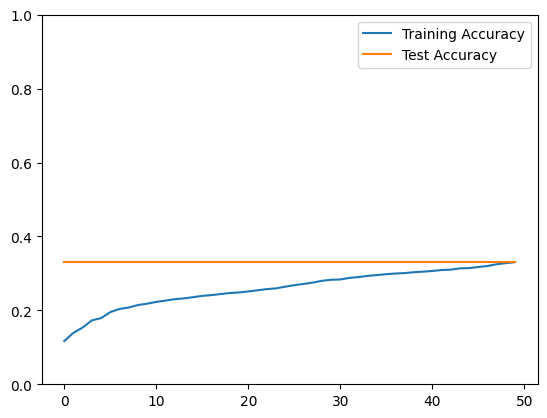

In [14]:
import numpy as np

x = np.arange(len(training_accuracies_for_sgd))
plt.plot(x, training_accuracies_for_sgd, label="Training Accuracy")
plt.plot(x, test_accuracies_for_sgd, label="Test Accuracy")
plt.legend()
plt.ylim([0, 1])
plt.show()

In [15]:
image_classifier_for_adam = SimpleImageClassificationModel(
    num_channels=3, image_width=32, image_height=32, num_output_classes=10
).to(device)
image_classifier_for_adam

SimpleImageClassificationModel(
  (layer1): Linear(in_features=3072, out_features=2048, bias=True)
  (layer2): Linear(in_features=2048, out_features=2048, bias=True)
  (layer3): Linear(in_features=2048, out_features=10, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
)

In [16]:
from torch.optim import Adam

adam_optimizer = Adam(image_classifier_for_adam.parameters(), lr=LEARNING_RATE)
adam_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [17]:
criterion_for_adam = nn.CrossEntropyLoss()

In [18]:
training_accuracies_for_adam = []

image_classifier_for_adam.train()
for epoch in range(EPOCHS):
    total = 0
    total_correctness = 0
    total_loss = 0.0

    for data in train_data_loader:
        adam_optimizer.zero_grad()  # gradient 초기화

        images, labels = data
        inputs, labels = images.to(device), labels.to(device)  # gpu 로 데이터 옮김

        outputs = image_classifier_for_adam(inputs)  # 학습

        loss = criterion_for_adam(outputs, labels)  # loss 계산
        loss.backward()  # 역전파

        adam_optimizer.step()  # 가중치 업데이트

        # 예측에 대한 정확도 계산
        predictions = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        total_correctness += (predictions == labels).sum().item()
        total_loss += loss.item()

    accuracy = total_correctness / total
    training_accuracies_for_adam.append(accuracy)
    print(
        f"Epoch {epoch + 1:3} | Total Loss: {total_loss:.5f} | Accuracy: {accuracy:.5f}"
    )

Epoch   1 | Total Loss: 418.39455 | Accuracy: 0.18198
Epoch   2 | Total Loss: 374.76398 | Accuracy: 0.29824
Epoch   3 | Total Loss: 355.55012 | Accuracy: 0.34224
Epoch   4 | Total Loss: 337.45980 | Accuracy: 0.37762
Epoch   5 | Total Loss: 325.70584 | Accuracy: 0.40014
Epoch   6 | Total Loss: 317.03679 | Accuracy: 0.42034
Epoch   7 | Total Loss: 307.91898 | Accuracy: 0.44172
Epoch   8 | Total Loss: 300.01505 | Accuracy: 0.45634
Epoch   9 | Total Loss: 295.48583 | Accuracy: 0.46300
Epoch  10 | Total Loss: 287.46449 | Accuracy: 0.47730
Epoch  11 | Total Loss: 283.57013 | Accuracy: 0.48542
Epoch  12 | Total Loss: 277.96238 | Accuracy: 0.49508
Epoch  13 | Total Loss: 274.74942 | Accuracy: 0.50088
Epoch  14 | Total Loss: 268.62629 | Accuracy: 0.51410
Epoch  15 | Total Loss: 265.49082 | Accuracy: 0.51974
Epoch  16 | Total Loss: 259.38730 | Accuracy: 0.53020
Epoch  17 | Total Loss: 255.09331 | Accuracy: 0.53898
Epoch  18 | Total Loss: 252.09329 | Accuracy: 0.54328
Epoch  19 | Total Loss: 248.

In [19]:
test_accuracies_for_adam = []
with torch.no_grad():
    for _ in range(EPOCHS):
        total_images = 0
        total_correctness = 0
        for data in test_data_loader:
            images, labels = data
            inputs, labels = images.to(device), labels.to(device)

            outputs = image_classifier_for_adam(inputs)

            predictions = torch.argmax(outputs, dim=1)

            total_images += labels.size(0)
            total_correctness += (predictions == labels).sum().item()
        accuracy = total_correctness / total_images
        test_accuracies_for_adam.append(accuracy)

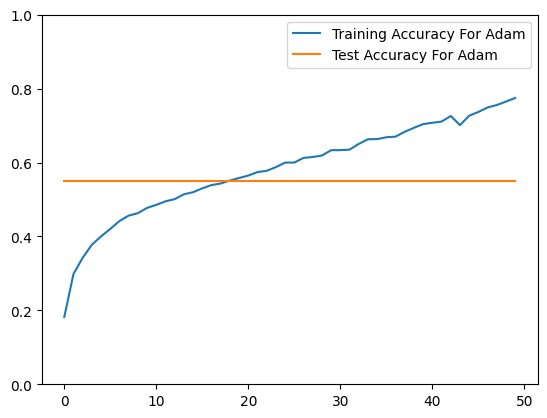

In [20]:
x = np.arange(len(training_accuracies_for_adam))
plt.plot(x, training_accuracies_for_adam, label="Training Accuracy For Adam")
plt.plot(x, test_accuracies_for_adam, label="Test Accuracy For Adam")
plt.legend()
plt.ylim([0, 1])
plt.show()